# Seventh Exercise (Chapter 3 & Chapter 14)

In the first part we will recap basics of probability theory. 

In the second part, we're going to implement an autoencoder and explore the learned latent space.

## 7.1 Probability

Solve the first two exercises mathematically. Answer using markdown and latex in this notebook. Please provide intermediate steps and explanations. 

### 7.1.1 Bertrand's Box Paradox

Consider a box containing the following 3 cards

- one with two black sides
- one with two white sides
- one with a black and a white side

From the three cards, one is drawn at random and put on the table. You can only see the side facing up.

**Questions:** 

a) What are the probabilities that the card on the table shows a black side? What are the probabilities it shows a white side?   
b) If we draw a card and it shows black, compute the probability that the other side of the card is also black.  
c) Find the the probability that the other side of the card is black if the card shows a white side.

**Answers:**  
_View the PDF document attached with the notebook._

## 7.1.2 Entropy and Kullback Leibler Divergence

**Questions:**

a) Compute the Entropy of the normal distribution

\begin{equation*}
\mathcal N(x; \mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{e}^{-\frac{(x-\mu)^2}{2\sigma^2}}\,.
\end{equation*}

b) Find the Kullback-Leibler divergence between two Gaussian distributions, i.e.

\begin{equation*}
D_{KL}\left( \mathcal N(\mu_1, \sigma_1) \vert\vert \mathcal N(\mu_2, \sigma_2) \right)\,.
\end{equation*}

**Answers:**  
_View the PDF document attached with the notebook._

## 7.1.3 Distributions and CLT

The central limit theorem states that for i.i.d. random samples $\{X_i\}$ from an (almost) arbitrary distribution with given mean $\mu$ and variance $\sigma^2$, the mean $\frac{1}{n}\sum_{i=1}^n X_i$ follows approximately a normal distribution. More precisely, it reads

\begin{equation*}
	\frac{1}{n} \sum_{i=1}^n X_i \xrightarrow{n\to\infty} \mathcal N(\mu, \frac{\sigma^2}{n})\,.
\end{equation*}

**Questions:**

- a) Draw $n=1,16,64, 1024$ samples from the distributions below for $1024$ times (each). Draw for each (n, distribution) pair a histogram over the sample mean. Include the corresponding normal distribution (pdf) in the plot.

    - the exponential distribution $p(X) = \lambda \mathrm{e}^{-\lambda X}$
    - the Gaussian/normal distribution 
- b) Assume, that you can only sample from uniform distributions. Implement functions to sample from an approximated standard normal distribution and an approximated normal distribution. Plot the distributions in comparison to the numpy implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# a)
## START TODO ########################

for n in [1, 16, 64, 1024]:
    means_exp = []
    means_norm = []
    for _ in range(1024):
        # Exponential
        means_exp.append(sum(np.random.exponential(size=n) / n))
        # Normal
        means_norm.append(sum(np.random.normal(size=n) / n))
    plt.figure()
    plt.title(f"n = {n}")
    plt.hist(means_exp, bins=50, label="Exponential", density=True)
    plt.hist(means_norm, bins=50, label="Normal", density=True)
    plt.legend()

## END TODO ########################

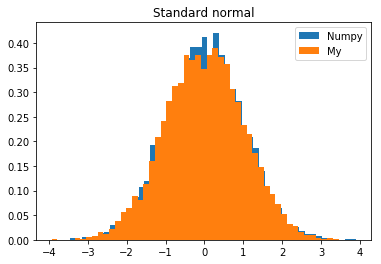

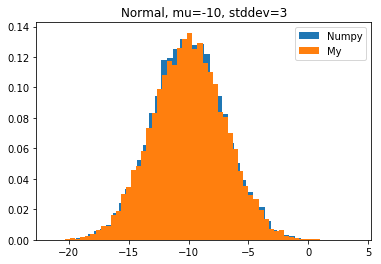

In [2]:
# b)

## START TODO ########################
def normal_uniform_sum(mean, stddev):
    return sum(np.random.uniform(-stddev, stddev) for _ in range(12)) / 2 + mean
## END TODO ########################

def std_normal(n_samples: int = 1) -> np.ndarray:
    """ Sample from a standard normal distribution. 
        The normal distribution is approximated via a uniform dist.
    
        n_samples: number of samples of a standard normal distribution
        return:    samples. length = n_samples
    """
    ## START TODO ########################
    return [normal_uniform_sum(0, 1) for _ in range(n_samples)]
    ## END TODO ########################
    # return value has len n_samples

def normal(loc: float = 0.0, scale: float = 1.0, n_samples: int = 1) -> np.ndarray:
    """ Sample from a normal distribution.
        The normal distribution is approximated via a uniform dist.
    
        loc: mean of the distribution
        scale: standard deviation spread of the distribution.
        
        n_samples: number of samples
        return:    samples. length = n_samples
    """
    ## START TODO ########################
    return [normal_uniform_sum(loc, scale) for _ in range(n_samples)]
    ## END TODO ########################


n_samples = 10000
bins = 20

# plot histograms for standard normal with std_normal and np.random.normal
## START TODO ########################
plt.figure()
plt.title("Standard normal")
plt.hist(np.random.normal(size=n_samples), bins=50, density=True, label="Numpy")
plt.hist(std_normal(n_samples), bins=50, density=True, label="My")
plt.legend()
## END TODO ########################

# plot histograms for N(mean=-10, std=3) with normal and np.random.normal
## START TODO ########################
plt.figure()
plt.title("Normal, mu=-10, stddev=3")
plt.hist(np.random.normal(loc=-10, scale=3, size=n_samples), bins=50, density=True, label="Numpy")
plt.hist(normal(loc=-10, scale=3, n_samples=n_samples), bins=50, density=True, label="My")
plt.legend()
## END TODO ########################

### Your Feedback on Exercise 7.1

* **Major Problems:**  
7.1.2 b) required some math tricks in order to get the integral into the "nice" form that is easy to calculate. 
* **Helpful?**  
Yes, the result of KL divergence was also needed later in the loss function implementation.
* **Duration (hours):**  
2 h
* **Other feedback:**  
We are not sure what was the purpose of task 7.1.3 (Distributions and CLT) in this exercise.

## 7.2 Autoencoder

Let's now implement our own variational auto encoder (VAE). The VAE is described in chapter 20.10.3 of the Deep Learning Book and you can find the original paper [here](https://arxiv.org/pdf/1312.6114.pdf).

Compared to a "standard" auto encoder, a VAE learns to approximate the posterior.

In [3]:
from __future__ import print_function
import os
import argparse
from typing import Tuple

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(0)
device = torch.device("cuda:0")

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

In [6]:
## START TODO ########################
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
## END TODO ########################

class VAE(nn.Module):
    def __init__(self, latent_space_size=2):
        """Variational auto encoder.
        
        Create the VAE with the MLP encoder having one hidden layer
        and two output layers (mean and log of the variance).
        Use a hidden size of 100 and each output size of `latent_space_size`.
        
        The decoder should be as powerful as the encoder.
        """
        ## START TODO ########################
        super().__init__()
        self.latent_space_size = latent_space_size
        
        # --- Encoder ---
        
        # Hidden layer
        hidden_size = 100
        self.hidden = nn.Sequential(
            Flatten(),
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(True)
        )
        
        # Mean
        self.mean = nn.Linear(hidden_size, latent_space_size)
        
        # Variance
        self.logvar = nn.Linear(hidden_size, latent_space_size)
        
        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 28 * 28),
            nn.Sigmoid()
        )

        ## END TODO ########################

    def encode(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Encode x to distribution.
        
        Compute the hidden representation. Estimate and return the mean
        and the log of the variance from the hidden representation. Use
        relu as activation function for the hidden representation.
        """
        ## START TODO ########################
        h = self.hidden(x)        
        mu = self.mean(h)
        logvar = self.logvar(h)

        if self.training:
            assert h.requires_grad, "h"
            assert mu.requires_grad, "mu"
            assert logvar.requires_grad, "logvar"

        return mu, logvar
        ## END TODO ########################

    def reparameterize(self, mu, logvar) -> torch.Tensor:
        """Sample from the estimated distribution.
        
        In training mode, return a sample from N(mu, logvar).
        In evaluation mode, just return the mean.
        
        Hint: You estimate the log of the variance, so you need to transform
        this to std deviation first, as torch.randn
        """
        ## START TODO ########################
        batch_size = mu.size(0)
        
        if self.training:
            eps = torch.stack([
                torch.distributions.multivariate_normal.MultivariateNormal(
                    torch.zeros(self.latent_space_size),
                    torch.eye(self.latent_space_size)
                ).sample().to(device) for _ in range(batch_size)
            ], dim=0)

            var = torch.exp(logvar)
            stddev = torch.sqrt(var)
            z = mu + stddev * eps
            assert mu.requires_grad
            assert stddev.requires_grad
            assert z.requires_grad, "z"
        else:
            z = mu

        return z
        ## End TODO ########################

    def decode(self, z) -> torch.Tensor:
        """ Decode the latent representation.
        
        Compute the hidden representation from the latent space z,
        use relu as activation. Then reconstruct the signal from
        the hidden representation, using a sigmoid as activation.
        """
        ## START TODO ########################
        return self.decoder(z)
        ## END TODO ########################

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Encode, reparameterize and decode.
        
        Returns:
            (The decoded result, mu, logvar)
        """
        ## START TODO ########################
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        ## END TODO ########################

In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_reconstructed, x, mu, logvar, kl_loss_weight=1):
    ## START TODO ########################
    # compute the binary cross entropy between x and the reconstructed x
    
    x_flattened = Flatten()(x)
    rec_loss = F.binary_cross_entropy(x_reconstructed, x_flattened, reduction="sum")
    
    # Here your results from 7.1.2 come into play - The first distribution is
    # the N(mu, logvar) and the second is N(0, 1). Plugging this into
    # the result from 7.1.2 yields
    # - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # you can also check Appendix B from the VAE paper:
    # https://arxiv.org/abs/1312.6114
    
    var = torch.exp(logvar)
    kl_div_loss = - 0.5 * torch.sum(1 + logvar - mu * mu - var)    
    ## END TODO ########################
    return rec_loss + kl_div_loss * kl_loss_weight

In [8]:
def train(model, epoch, optimizer, kl_loss_weight=1, save_images=False):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = loss_function(reconstructed_batch, data, mu, logvar, kl_loss_weight)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if save_images:
        n = min(data.size(0), 8)
        training_image = torch.cat([data[:n]])
        save_image(training_image.cpu(),
                   'results/training_samples_' + str(epoch) + '.png', nrow=n)

    print('====> Epoch: {} Average train set loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(model, epoch, kl_loss_weight=1, save_images=False):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            reconstructed_batch, mu, logvar = model(data)
            test_loss += loss_function(reconstructed_batch, data, mu, logvar, kl_loss_weight).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      reconstructed_batch.view(128, 1, 28, 28)[:n]])
                if not save_images:
                    continue
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Average test set loss: {:.4f}'.format(test_loss))

In [9]:
latent_space_size = 2
model = VAE(latent_space_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if not os.path.isdir('results'):
    os.mkdir('results')

for epoch in range(1, 15):
    train(model, epoch, optimizer, save_images=True)
    test(model, epoch, save_images=True)
    with torch.no_grad():
        ## START TODO ########################
        # sample 64 images (generate a random latent_space and decode)
        z = torch.from_numpy(np.random.uniform(low=-1, high=1, size=(64, 2))).float().to(device)
        sample = model.decode(z)
        ## END TODO ########################
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')


====> Epoch: 1 Average train set loss: 211.7103
====> Average test set loss: 181.3877
====> Epoch: 2 Average train set loss: 178.3984
====> Average test set loss: 172.7767
====> Epoch: 3 Average train set loss: 172.7598
====> Average test set loss: 169.1115
====> Epoch: 4 Average train set loss: 169.7150
====> Average test set loss: 167.2504
====> Epoch: 5 Average train set loss: 167.4504
====> Average test set loss: 165.1186
====> Epoch: 6 Average train set loss: 165.5760
====> Average test set loss: 163.4305
====> Epoch: 7 Average train set loss: 164.1500
====> Average test set loss: 162.2265
====> Epoch: 8 Average train set loss: 163.0250
====> Average test set loss: 161.4878
====> Epoch: 9 Average train set loss: 162.0832
====> Average test set loss: 160.3347
====> Epoch: 10 Average train set loss: 161.4032
====> Average test set loss: 159.9737
====> Epoch: 11 Average train set loss: 160.7503
====> Average test set loss: 159.3431
====> Epoch: 12 Average train set loss: 160.1974
===

## Exploring the latent space

One of the easiest ways to visualize the latent space is to limit the size to two dimensions (which of course might not always capture the data well) and to sample from the model over a 2D grid. This is what we're going to do below. Also, we can nicely visualize the concept of a VAE. We plot the mean over the estimated means for each class (the numbers 0 to 9) and the mean estimated standard deviation for each class (the blue crosses).

Per class mean of estimated mean:
 [[-0.824712   -0.43725249  0.26174602  0.7775306   0.69576793  0.81682798
  -0.14536495  1.51836703  1.18227704  0.91707359]
 [ 1.99233068 -2.49489994  0.91790796  0.65414372 -0.39141891  0.32271557
   1.14694266 -0.98247048  0.31925996 -0.55788263]]
Per class mean of estimated std deviation:
 [[0.08540849 0.11428378 0.08671728 0.0839715  0.11519391 0.10526536
  0.06917805 0.12252603 0.11854591 0.10296638]
 [0.11659727 0.17588576 0.08328812 0.0751798  0.07299982 0.08843333
  0.09183377 0.07727366 0.0885977  0.07258903]]


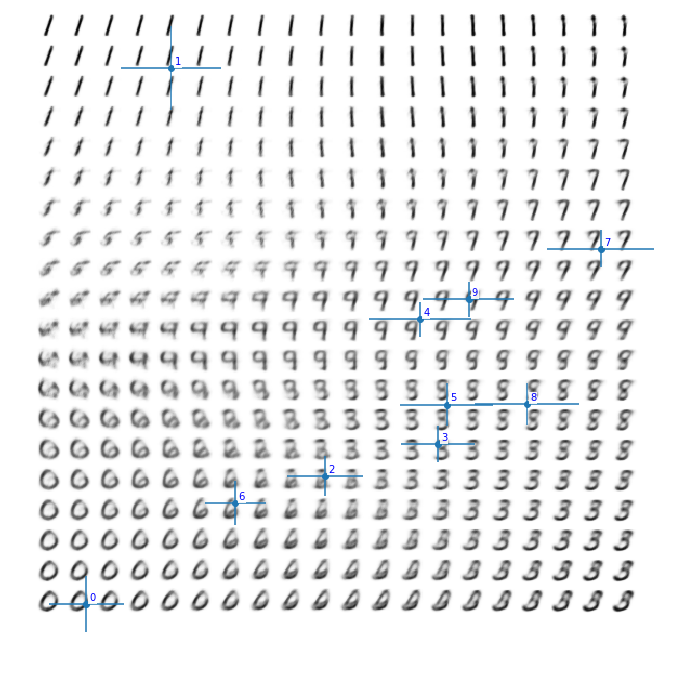

In [16]:
def get_mu_logvar(model: nn.Module) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute the model's prediction of mean and logvar for all
       images in the MNIST test set.
    """
    mus, logvars = [], []
    # encode each image of the test_loader
    ## START TODO ########################
    for data, _ in test_loader:
        data = data.to(device)
        mu, logvar = model.encode(data)
        mus.append(mu.cpu())
        logvars.append(logvar.cpu())
    ## END TODO ########################
    return torch.cat(mus, dim=0), torch.cat(logvars, dim=0)

    
def sample_on_grid(latent_min: Tuple[int, int], latent_max: Tuple[int, int], 
                   model: nn.Module, grid_size: int) -> Tuple[np.ndarray, np.ndarray]:
    ## START TODO ########################
    # create a grid in two directions from latent_min to latent_max, using
    # the respective dimension
    # x1 = ...
    # x2 = ...
    # use the created grid as latent variables and run them through the decoder
    x1 = np.arange(latent_min[0], latent_max[0], (latent_max[0] - latent_min[0]) / grid_size)
    x2 = np.arange(latent_min[1], latent_max[1], (latent_max[1] - latent_min[1]) / grid_size)
    
    decoded = np.zeros(shape=(grid_size, grid_size, 28 * 28))
    model.eval()
    for j in range(grid_size):
        for i in range(grid_size):
            out = model.decode(torch.tensor([x1[i], x2[j]]).to(device))
            decoded[j, i] = out.cpu().detach().numpy()
    
    ## END TODO ########################
    step_size = np.array((x1[1] - x1[0], x2[1] - x2[0]))
    return decoded.reshape(grid_size, grid_size, 28, 28), step_size


def plot_latent_space(model: nn.Module):
    model.eval()
    mus, logvars = get_mu_logvar(model)
    mus = mus.detach().numpy()
    stddev = np.exp(0.5*logvars.detach().numpy())

    labels = torch.cat([label for _, label in test_loader]).detach().numpy()
    num_samples = labels.shape[0]
    class_mu_0 = np.bincount(labels, weights=mus[:, 0]) / np.bincount(labels)
    class_mu_1 = np.bincount(labels, weights=mus[:, 1]) / np.bincount(labels)
    mean_mu = np.stack((class_mu_0, class_mu_1))
    print("Per class mean of estimated mean:\n", mean_mu)

    class_stddev_0 = np.bincount(labels, weights=stddev[:, 0]) / np.bincount(labels)
    class_stddev_1 = np.bincount(labels, weights=stddev[:, 1]) / np.bincount(labels)
    mean_stddev = np.stack((class_stddev_0, class_stddev_1))
    print("Per class mean of estimated std deviation:\n", mean_stddev)

    # get the minimum and maximum values of the latent space means
    # we will use this as boundaries from which we sample in the latent space
    latent_min = np.min(mean_mu - mean_stddev * 2, axis=1)
    latent_max = np.max(mean_mu + mean_stddev * 2, axis=1)

    # Produce a 20x20 2D grid of evenly spaced values between latent_min ant latent_max
    decoded, step_size = sample_on_grid(latent_min, latent_max, model, grid_size=20)
    
    # visualize the decoded images
    # using reshape and np.concatenate and calling imshow only once
    # is a lot faster than creating a subplot and calling imshow 400 times.
    # It's also necessary to be able to plot the means
    block_img = np.concatenate(np.concatenate(decoded, axis=1), axis=1)
    f = plt.figure(figsize=(12,12))
    plt.imshow(block_img, cmap='Greys')
    plt.axis('off');

    # visualize the mean mu and the mean standard deviation of each class
    # scale the mean accordingly, as the plot's axes represent pixels
    scale = (28 / step_size)

    mean_mu_scaled = 28/2 + scale.reshape(2, 1) * (mean_mu - latent_min.reshape(2,1))
    # we scale the stddev by 2 so the arrows are extended a bit more
    mean_stddev_scaled = mean_stddev * scale.reshape(2, 1) * 2
    # plot the std deviation
    plt.errorbar(mean_mu_scaled[0], mean_mu_scaled[1],
                 yerr=mean_stddev_scaled[1], xerr=mean_stddev_scaled[0],
                 linestyle='None')
    # plot the means
    plt.scatter(mean_mu_scaled[0], mean_mu_scaled[1])

    for i, txt in enumerate([str(i) for i in range(0,10)]):
        plt.annotate(txt, (mean_mu_scaled[0][i] + 3, mean_mu_scaled[1][i] - 3),
                     color='blue',
                     bbox={'facecolor':'white', 'alpha':0.9, 'pad':1, 'edgecolor':'none'})
    plt.show()

plot_latent_space(model)

## Exploring the influence of the KL-divergence in the loss

Let's now investigate the influence of the KL-divergence by training
- one model where we weight the KL-divergence part of the loss by a factor of 30 and
- one model where we remove it (weight 0).

Visualize the latent space as we did above.

**ToDo** What do you observe? How can these results be explained? What is the role of the KL divergence term?

With a large KL divergence penalty, the whole latent space collapses to our prior, i.e. for every class we get a standard normal distribution against which we calculated the KL divergence.

When KL divergence term is removed from the objective, the prior distribution is completely ignored and the network only maximizes the likelihood of the given data.

Having said that, the KL divergence term makes the autoencoder network generalize better, i.e. it serves as a regularization term in the loss function keeping the distribution closer to the prior.

In [11]:
## START TODO ######################## 
latent_space_size = 2
model_large_kl = VAE(latent_space_size).to(device)
optimizer = optim.Adam(model_large_kl.parameters(), lr=1e-3)

for epoch in range(1, 15):
    train(model_large_kl, epoch, optimizer, kl_loss_weight=30, save_images=False)
## END TODO ########################

====> Epoch: 1 Average train set loss: 239.4362
====> Epoch: 2 Average train set loss: 207.0210
====> Epoch: 3 Average train set loss: 206.5138
====> Epoch: 4 Average train set loss: 206.3440
====> Epoch: 5 Average train set loss: 206.3309
====> Epoch: 6 Average train set loss: 206.3019
====> Epoch: 7 Average train set loss: 206.2900
====> Epoch: 8 Average train set loss: 206.2729
====> Epoch: 9 Average train set loss: 206.2494
====> Epoch: 10 Average train set loss: 206.2286
====> Epoch: 11 Average train set loss: 206.2282
====> Epoch: 12 Average train set loss: 206.2307
====> Epoch: 13 Average train set loss: 206.2102
====> Epoch: 14 Average train set loss: 206.2219


Per class mean of estimated mean:
 [[-0.00178137 -0.00417105 -0.00518777  0.0029608   0.00111247  0.00426839
  -0.00377954  0.00366826  0.00323537  0.00318514]
 [ 0.05791782 -0.03049507  0.00989382  0.00553148 -0.0071772   0.00565539
   0.0141355  -0.02024276 -0.00139938 -0.01409063]]
Per class mean of estimated std deviation:
 [[0.93483122 1.04650029 0.98650158 0.99273549 1.00705809 0.99423251
  0.98720454 1.02071126 1.00015732 1.01523192]
 [0.94117361 1.03702173 0.98854467 0.99424408 1.00729251 0.9949596
  0.98679647 1.02061354 1.00126645 1.01479669]]


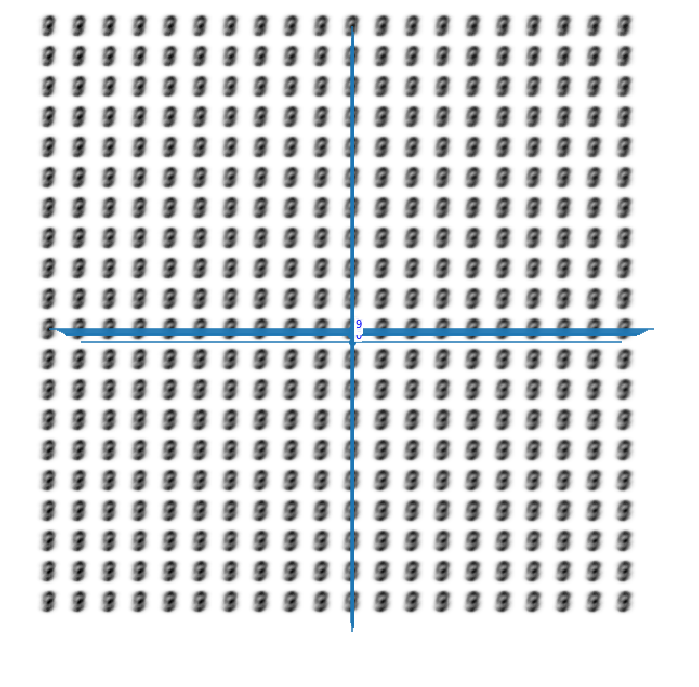

In [17]:
plot_latent_space(model_large_kl)

In [20]:
## START TODO ########################
latent_space_size = 2
model_no_kl = VAE(latent_space_size).to(device)
optimizer = optim.Adam(model_no_kl.parameters(), lr=1e-3)

for epoch in range(1, 15):
    train(model_no_kl, epoch, optimizer, kl_loss_weight=0, save_images=False)
## END TODO ########################

====> Epoch: 1 Average train set loss: 198.3624
====> Epoch: 2 Average train set loss: 171.0354
====> Epoch: 3 Average train set loss: 165.7076
====> Epoch: 4 Average train set loss: 162.8491
====> Epoch: 5 Average train set loss: 160.9034
====> Epoch: 6 Average train set loss: 159.3258
====> Epoch: 7 Average train set loss: 157.9857
====> Epoch: 8 Average train set loss: 156.8528
====> Epoch: 9 Average train set loss: 155.9437
====> Epoch: 10 Average train set loss: 155.1276
====> Epoch: 11 Average train set loss: 154.4566
====> Epoch: 12 Average train set loss: 153.8502
====> Epoch: 13 Average train set loss: 153.2635
====> Epoch: 14 Average train set loss: 152.8065


Per class mean of estimated mean:
 [[  9.72177559 -15.06797625   4.40032406   5.05720768   0.90856442
    4.71485304   5.71746413   2.14649366   5.66234928   2.08320377]
 [ -2.31238525  19.42989592   1.5668942    4.06031273   5.69045096
    5.6659944    0.54409243  11.82191347   6.76596578   8.92364989]]
Per class mean of estimated std deviation:
 [[0.00074013 0.0031973  0.00148943 0.00070802 0.0005806  0.00074957
  0.00143064 0.00090891 0.00038221 0.00040539]
 [0.00084313 0.00304506 0.00175484 0.00093699 0.00107453 0.00117272
  0.00154655 0.0012656  0.00054384 0.00070342]]


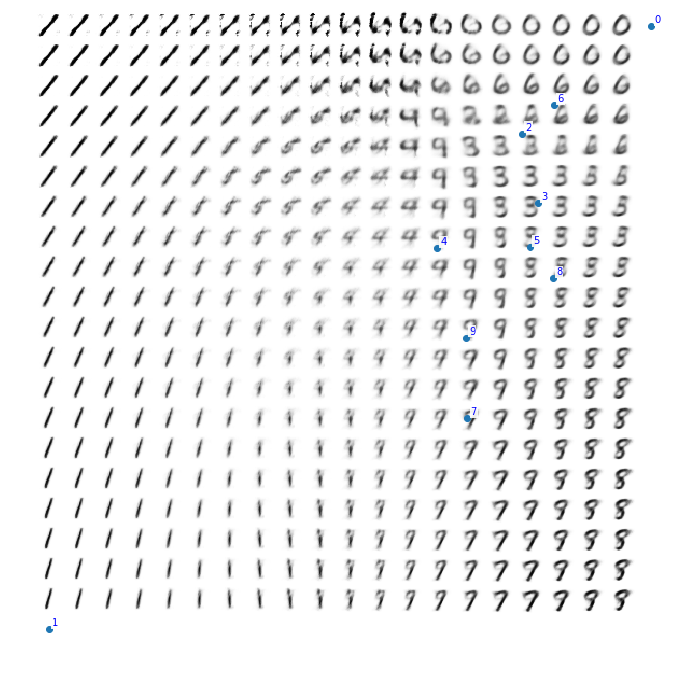

In [21]:
plot_latent_space(model_no_kl)

### Your Feedback on Exercise 7.2

- **Major Problems:**  
We were encoding the variance instead of the log variance. Since it produces also negative numbers, taking the log was yielding NaNs. Another problem was that we sampled only one number (epsilon) per batch instead of one for each sample from the batch. That produced blurry results during the reconstruction.
- **Helpful?**  
Very, because we finally understood the theory behind the variational inference and VAEs.
- **Duration (hours):**  
4 h